# Benchmarking Multiphase Monte Carlo Sampling

# Motivation

As a methods researcher one is often interested in testing new methods and benchmarking them together with state-of-the-art algorithms.
hopsy provides the framework for conducting such comparisons, because it allows the methods researcher to focus on the algorithms, while the scaffolding, i.e., I/O, convergence diagnostics, and state-of-the-art implementations of existing algorithms are provided.


We show in this notebook how one can adapt build a multiphase monte carlo sampling plugin for hopsy

## Background
Instead of rounding before sampling, multiphase monte carlo sampling rounds adaptively based on the samples of the Markov chain during a run.
It has been reported to be an efficient strategy, if the underlying Markov chain is efficient enough.

The Idea has found previous adaption in the artificially centered coordinate hit-and-run and the optGP sampler.
However, Coordinate Hit-and-Run Rounded showed greater and more stable performance (https://pubmed.ncbi.nlm.nih.gov/28158334/) than both of those algorithms.

The idea is resurrected and shown to be efficient given a better Markov chain implementation.
See https://drops.dagstuhl.de/opus/volltexte/2021/13820/pdf/LIPIcs-SoCG-2021-21.pdf

In [1]:
import hopsy
from matplotlib import pyplot as plt
import numpy as np
from typing import List
import time
import PolyRound

# Custom proposals
In case the proposal you want to benchmark is not already implemented, it is possible 
to implement it yourself in a small class. It is then possible to seamlessy integrate this proposal
into existing workflows with hopsy. As an example, we implement
Overrelaxed Hit-and-Run, see https://ui.adsabs.harvard.edu/abs/2015IJMPC..2650010D/abstract 

In [2]:
class OverrelaxedHitAndRunProposal:
    def __init__(
        self, problem: hopsy.Problem, starting_point: np.ndarray, epsilon: float = 1e-10
    ):
        self.A = problem.A
        self.b = problem.b
        self.state = starting_point
        self.proposal = self.state
        self.epsilon = epsilon

    def propose(self, rng) -> np.ndarray:
        """This method is called by hopsy.MarkovChain. Returns the proposal"""
        direction = np.random.randn(self.state.shape[0])
        direction /= np.linalg.norm(direction, axis=0)

        inverse_distances = np.nan_to_num(
            np.divide(
                self.A @ direction, self.b - self.A @ self.state, self.A @ direction
            )
        )
        forward_distance = 1.0 / np.max(inverse_distances)
        backward_distance = 1.0 / np.min(inverse_distances)

        L = forward_distance - backward_distance
        a = 2 * (-backward_distance) / L - 1
        if a == 0:
            a = self.epsilon
        t_1 = (
            L * (1 + a - np.sqrt((1 + a) ** 2 - 4 * a * np.random.uniform())) / (2 * a)
        )
        t_0 = -backward_distance

        self.proposal = self.state + (t_1 - t_0) * direction
        return self.proposal

# More complex custom sampling schemes
In addition to custom proposals, it is also possible to implement adaptive workflows.
In this case we implement the adaptive rounding from https://drops.dagstuhl.de/opus/volltexte/2021/13820/pdf/LIPIcs-SoCG-2021-21.pdf using the Billiard walk that is already implemented in hopsy.

In [3]:
# rounding based on samples, as suggested in https://drops.dagstuhl.de/opus/volltexte/2021/13820/pdf/LIPIcs-SoCG-2021-21.pdf
def svd_rounding(samples, polytope):
    # We concatenate them samples to [n_dim, n_iterations] for rounding
    stacked_samples = np.vstack(
        (samples[0, :, :], samples[1, :, :], samples[2, :, :], samples[3, :, :])
    )

    mean = np.mean(stacked_samples, axis=0)
    stacked_samples = stacked_samples - mean
    U, S, Vh = np.linalg.svd(stacked_samples)
    # Rescaling as mentioned in  https://drops.dagstuhl.de/opus/volltexte/2021/13820/pdf/LIPIcs-SoCG-2021-21.pdf
    s_ratio = np.max(S) / np.min(S)
    S = S / np.min(S)
    if np.max(S) >= 2.0:
        S[np.where(S < 2.0)] = 1.0
    else:
        S = np.ones(S.shape)
        Vh = np.identity(Vh.shape[0])

    rounding_matrix = np.transpose(Vh).dot(np.diag(S))

    # Transforms current last samples into new polytope
    sub_problem = hopsy.Problem(
        polytope.A, polytope.b, transformation=rounding_matrix, shift=mean
    )
    starting_points = hopsy.transform(
        sub_problem, [samples[i, -1, :] for i in range(samples.shape[0])]
    )
    polytope.apply_shift(mean)
    polytope.apply_transformation(rounding_matrix)

    return s_ratio, starting_points, polytope, sub_problem

# Helper functions

In this section we implement some helper functions for executing the benchmarks as well as a function
which constructs our benchmark problems

In [4]:
# Helper functions for calling the sampling algorithms and defining the polytopes
def run_multiphase_sampling(
    proposal,
    polytope,
    seeds: List,
    target_ess: float,
    steps_per_phase: int,
    starting_points: List,
):
    limit_singular_ratio_value = 2.3  # from https://drops.dagstuhl.de/opus/volltexte/2021/13820/pdf/LIPIcs-SoCG-2021-21.pdf
    assert len(starting_points) == len(seeds)
    rngs = [hopsy.RandomNumberGenerator(s) for s in seeds]

    ess = 0
    iterations = 0
    s_ratio = limit_singular_ratio_value + 1
    sampling_time = 0
    samples = None
    last_iteration_did_rounding = True
    while ess < target_ess:
        iterations += 1
        print("\t\titer:", iterations)
        internal_polytope = polytope
        p = hopsy.Problem(internal_polytope.A, internal_polytope.b)
        markov_chains = [
            hopsy.MarkovChain(proposal=proposal, problem=p, starting_point=s)
            for s in starting_points
        ]

        start = time.time()
        acceptance_rate, _samples = hopsy.sample(
            markov_chains, rngs, n_samples=steps_per_phase, thinning=1, n_procs=1
        )
        end = time.time()
        assert 0 < np.min(p.b - p.A @ _samples[0, -1, :])
        assert 0 < np.min(p.b - p.A @ _samples[1, -1, :])
        assert 0 < np.min(p.b - p.A @ _samples[2, -1, :])
        assert 0 < np.min(p.b - p.A @ _samples[3, -1, :])
        sampling_time += end - start

        if s_ratio > limit_singular_ratio_value:
            samples = _samples
            # also measures the rounding time
            start = time.time()
            s_ratio, starting_points, internal_polytope, sub_problem = svd_rounding(
                samples, internal_polytope
            )
            end = time.time()
            sampling_time += end - start
            print("\t\ts_ratio:", s_ratio)
            last_iteration_did_rounding = True
        else:
            if last_iteration_did_rounding:
                # next operation transforms last samples to current space before concatenating
                for j in range(samples.shape[0]):
                    samples[j] = hopsy.transform(
                        sub_problem, [samples[j, i, :] for i in range(samples.shape[1])]
                    )
                last_iteration_did_rounding = False

            samples = np.concatenate((samples, _samples), axis=1)
            starting_points = [samples[i, -1, :] for i in range(samples.shape[0])]
        ess = np.min(hopsy.ess(samples))
        print("\t\tess", str(ess))
        steps_per_phase += 100

    # transforms back to full space
    _samples = np.zeros(
        (samples.shape[0], samples.shape[1], polytope.transformation.shape[0])
    )
    for j in range(samples.shape[0]):
        _samples[j] = hopsy.back_transform(
            hopsy.Problem(
                A=internal_polytope.A,
                b=internal_polytope.b,
                transformation=internal_polytope.transformation,
                shift=internal_polytope.shift,
            ),
            [samples[j, i, :] for i in range(samples.shape[1])],
        )

    return _samples, iterations, ess, sampling_time


def run_sampling(
    proposal,
    polytope,
    seeds: List,
    target_ess: float,
    steps_per_phase: int,
    starting_points: List,
    thinning=None,
):
    rngs = [hopsy.RandomNumberGenerator(s) for s in seeds]

    problem = hopsy.Problem(polytope.A, polytope.b)
    thinning = (
        thinning if thinning is not None else int(float(problem.A.shape[1] ** 2) / 6)
    )
    ess = 0
    iterations = 0
    # also measures the rounding time
    start = time.time()
    rounded_problem = hopsy.round(problem)
    # transforms starting points into rounded space
    starting_points = hopsy.transform(rounded_problem, starting_points)
    end = time.time()
    sampling_time = end - start
    samples = None
    markov_chains = [
        hopsy.MarkovChain(problem=rounded_problem, starting_point=s)
        for s in starting_points
    ]
    while ess < target_ess:
        iterations += 1
        print("\t\titer:", iterations)
        for i in range(len(starting_points)):
            markov_chains[i].proposal = proposal(
                rounded_problem, starting_point=starting_points[i]
            )

        start = time.time()
        acceptance_rate, _samples = hopsy.sample(
            markov_chains, rngs, n_samples=steps_per_phase, thinning=thinning, n_procs=1
        )
        end = time.time()
        sampling_time += end - start

        samples = (
            _samples if samples is None else np.concatenate((samples, _samples), axis=1)
        )
        starting_points = hopsy.transform(rounded_problem, samples[:, -1, :])

        ess = np.min(hopsy.ess(samples))
        print("\t\tess", str(ess) + ",", "samples", samples.shape[1])

    # transforms back to full space
    _samples = np.zeros(
        (samples.shape[0], samples.shape[1], polytope.transformation.shape[0])
    )
    for j in range(samples.shape[0]):
        _samples[j] = hopsy.back_transform(
            hopsy.Problem(
                A=polytope.A,
                b=polytope.b,
                transformation=polytope.transformation,
                shift=polytope.shift,
            ),
            [samples[j, i, :] for i in range(samples.shape[1])],
        )
    return _samples, iterations, ess, sampling_time


def generate_polytope(name):
    if name == "BP5":
        bp = hopsy.BirkhoffPolytope(5)
        polytope = PolyRound.mutable_classes.polytope.Polytope(A=bp.A, b=bp.b)
        polytope.normalize()
        parameter_names = ["x" + str(c) for c in polytope.A.columns]
        return polytope, "5D Birkhoff Polytope", parameter_names
    elif name == "e_coli":
        original_polytope = PolyRound.static_classes.parse_sbml_stoichiometry.StoichiometryParser.parse_sbml_cobrapy(
            "../extern/hops/resources/e_coli_core/e_coli_core.xml"
        )
        parameter_names = original_polytope.A.columns
        polytope = PolyRound.api.PolyRoundApi.simplify_polytope(original_polytope)
        polytope = PolyRound.api.PolyRoundApi.transform_polytope(polytope)
        polytope.normalize()
        return polytope, "e_coli_core", parameter_names

# Benchmark parameters

Next set up the benchmark parameters

In [5]:
target_ess = 1000
proposalTypes = {
    "Billiard walk": hopsy.BilliardWalkProposal,
    "CHRRT": hopsy.UniformCoordinateHitAndRunProposal,
    "OHRR": OverrelaxedHitAndRunProposal,
}
seeds = [1, 2, 3, 4]

problems_to_benchmark = ["BP5", "e_coli"]

# Benchmarking

Sample all problems with all sampling schemes, i.e., two for loops.

In [6]:
samples = {}
iterations = {}
ess = {}
times = {}
ess_t = {}

for problem_selection in problems_to_benchmark:
    print("Benchmarking {problem_selection}")
    samples[problem_selection] = {}
    iterations[problem_selection] = {}
    ess[problem_selection] = {}
    times[problem_selection] = {}
    ess_t[problem_selection] = {}
    for name, p in proposalTypes.items():
        print("\tproposal", name)
        # resets problem and starting points
        preprocessed_polytope, problem_name, parameter_names = generate_polytope(
            problem_selection
        )
        steps_per_phase = preprocessed_polytope.A.shape[1] * 20
        cheby = hopsy.compute_chebyshev_center(
            hopsy.Problem(A=preprocessed_polytope.A, b=preprocessed_polytope.b)
        ).flatten()
        starting_points = [cheby for s in seeds]

        if name == "Billiard walk":
            (
                samples[problem_selection][name],
                iterations[problem_selection][name],
                ess[problem_selection][name],
                times[problem_selection][name],
            ) = run_multiphase_sampling(
                proposal=p,
                polytope=preprocessed_polytope,
                seeds=seeds,
                target_ess=target_ess,
                steps_per_phase=steps_per_phase,
                starting_points=starting_points,
            )
        else:
            thinning = (
                1
                if name != "CHRRT"
                else max(int(float(preprocessed_polytope.A.shape[1] ** 2) / 6), 1)
            )
            samples[problem_selection][name], iterations[problem_selection][name], ess[problem_selection][name], times[problem_selection][name] = run_sampling(
                proposal=p,
                polytope=preprocessed_polytope,
                seeds=seeds,
                target_ess=target_ess,
                steps_per_phase=steps_per_phase,
                starting_points=starting_points,
                thinning=thinning,
            )
        ess_t[problem_selection][name] = ess[problem_selection][name] / times[problem_selection][name]

    # check convergence
    for name, s in samples[problem_selection].items():
        print("\t" + name, "rhat:", np.max(hopsy.rhat(s)))
    
    print("\tess", ess[problem_selection])
    print("\ttimes", times[problem_selection])
    print("\tess/t", ess_t[problem_selection])

Benchmarking {problem_selection}
	proposal Billiard walk
Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-30
		iter: 1
		s_ratio: 1.3847452299003389
		ess 231.4835868364245
		iter: 2
		ess 627.6793244654275
		iter: 3
		ess 990.5612889618237
		iter: 4
		ess 1583.2881720652492
	proposal CHRRT
		iter: 1
		ess 453.9004456107389, samples 320
		iter: 2
		ess 894.4609120329771, samples 640
		iter: 3
		ess 1321.6148361675992, samples 960
	proposal OHRR
		iter: 1
		ess 7.625745323520432, samples 320
		iter: 2
		ess 7.6054662230477454, samples 640
		iter: 3
		ess 12.38432877661255, samples 960
		iter: 4
		ess 13.182005874239481, samples 1280
		iter: 5
		ess 12.401342018005563, samples 1600
		iter: 6
		ess 22.244281110746087, samples 1920
		iter: 7
		ess 25.62949774599076, samples 2240
		iter: 8
		ess 34.04845549392683, samples 2560
		iter: 9
		ess 45.30986010578385, samples 2880
		iter: 10
		ess 60.94902208036537, samples 3200
		iter: 11
		ess 80.4997482348

# Visualizing the results

In [7]:
title_fs = 32
label_fs = 20
tick_fs = 16
legend_fs = 16
img_format = "pdf"

In [8]:
times_to_plot = {}
ess_t_to_plot = {}

# restructure dicts for easier plotting
for n,p in proposalTypes.items():
    times_to_plot[n] = {}
    ess_t_to_plot[n] = {}
    for problem_selection in problems_to_benchmark:
        times_to_plot[n][problem_selection] = times[problem_selection][n] 
        ess_t_to_plot[n][problem_selection] = ess_t[problem_selection][n] 

## visualize runtimes

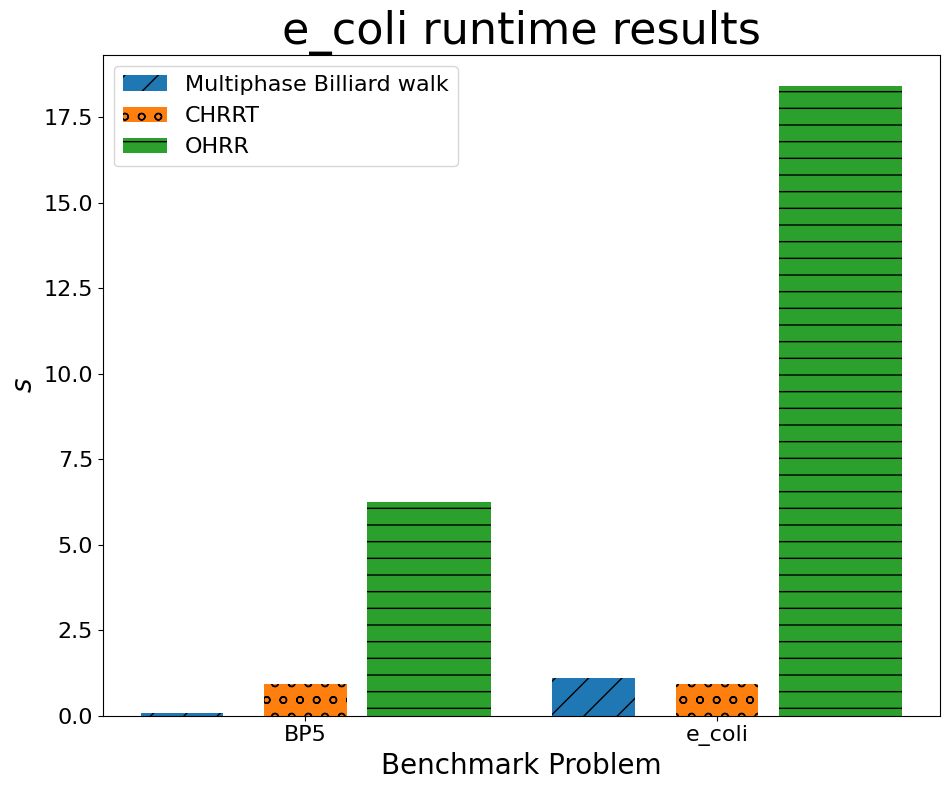

In [9]:
plt.figure(figsize=(1.5 * 6.4, 8))
plt.title(problem_selection + " runtime results", fontsize=title_fs)

X_ticks = problems_to_benchmark

X_axis = np.arange(len(X_ticks))
plt.bar(X_axis - 0.3, times_to_plot["Billiard walk"].values(), 0.2, hatch="/", label="Multiphase Billiard walk")
plt.bar(X_axis - 0.0, times_to_plot["CHRRT"].values(), 0.2, hatch="o", label="CHRRT")
plt.bar(X_axis + .3, times_to_plot["OHRR"].values(), 0.3, hatch='-', label='OHRR')

plt.ylabel(r"$s$", fontsize=label_fs)
plt.xlabel(r"Benchmark Problem", fontsize=label_fs)
plt.xticks(X_axis, X_ticks, fontsize=tick_fs)
plt.yticks(fontsize=tick_fs)

plt.tight_layout()

plt.legend(fontsize=legend_fs)
plt.savefig("BenchmarkRuntimeResults.pdf")
plt.show()

## visualize ESS/t [1/s]

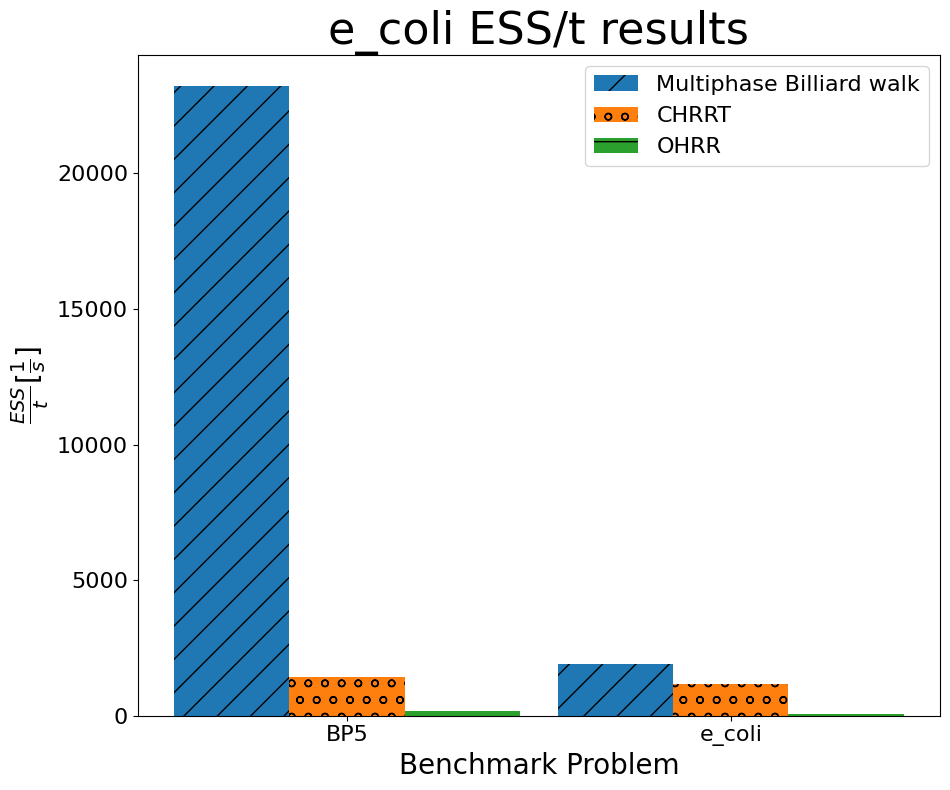

In [10]:
plt.figure(figsize=(1.5 * 6.4, 8))
plt.title(problem_selection + " ESS/t results", fontsize=title_fs)

X_ticks = problems_to_benchmark

X_axis = np.arange(len(X_ticks))
plt.bar(X_axis - 0.3, ess_t_to_plot["Billiard walk"].values(), 0.3, hatch="/", label="Multiphase Billiard walk")
plt.bar(X_axis - 0.0, ess_t_to_plot["CHRRT"].values(), 0.3, hatch="o", label="CHRRT")
plt.bar(X_axis + .3, ess_t_to_plot["OHRR"].values(), 0.3, hatch='-', label='OHRR')

plt.ylabel(r"$\frac{\mathit{ESS}}{t} [\frac{1}{s}]$", fontsize=label_fs)
plt.xlabel(r"Benchmark Problem", fontsize=label_fs)
plt.xticks(X_axis, X_ticks, fontsize=tick_fs)
plt.yticks(fontsize=tick_fs)

plt.tight_layout()

plt.legend(fontsize=legend_fs)
plt.savefig("BenchmarkPerformanceResults.pdf")
plt.show()

# Conclusion

In this benchmark the overrelaxed hit and run does not perform well against modern 
sampling algorithms. Furthermore we can see, that the performance is problem dependendent.

The values of the benchmark are not the main result of this script, however.
Much more important is that hopsy is flexible enough to quickly construct fair benchmarks comparing
novel algorithms with existing implementations. Furthermore all sampling algorithms access the models (polytopes) via the same interface, which reduces work for the methods researcher.

# Appendix

## Visualizing the samples

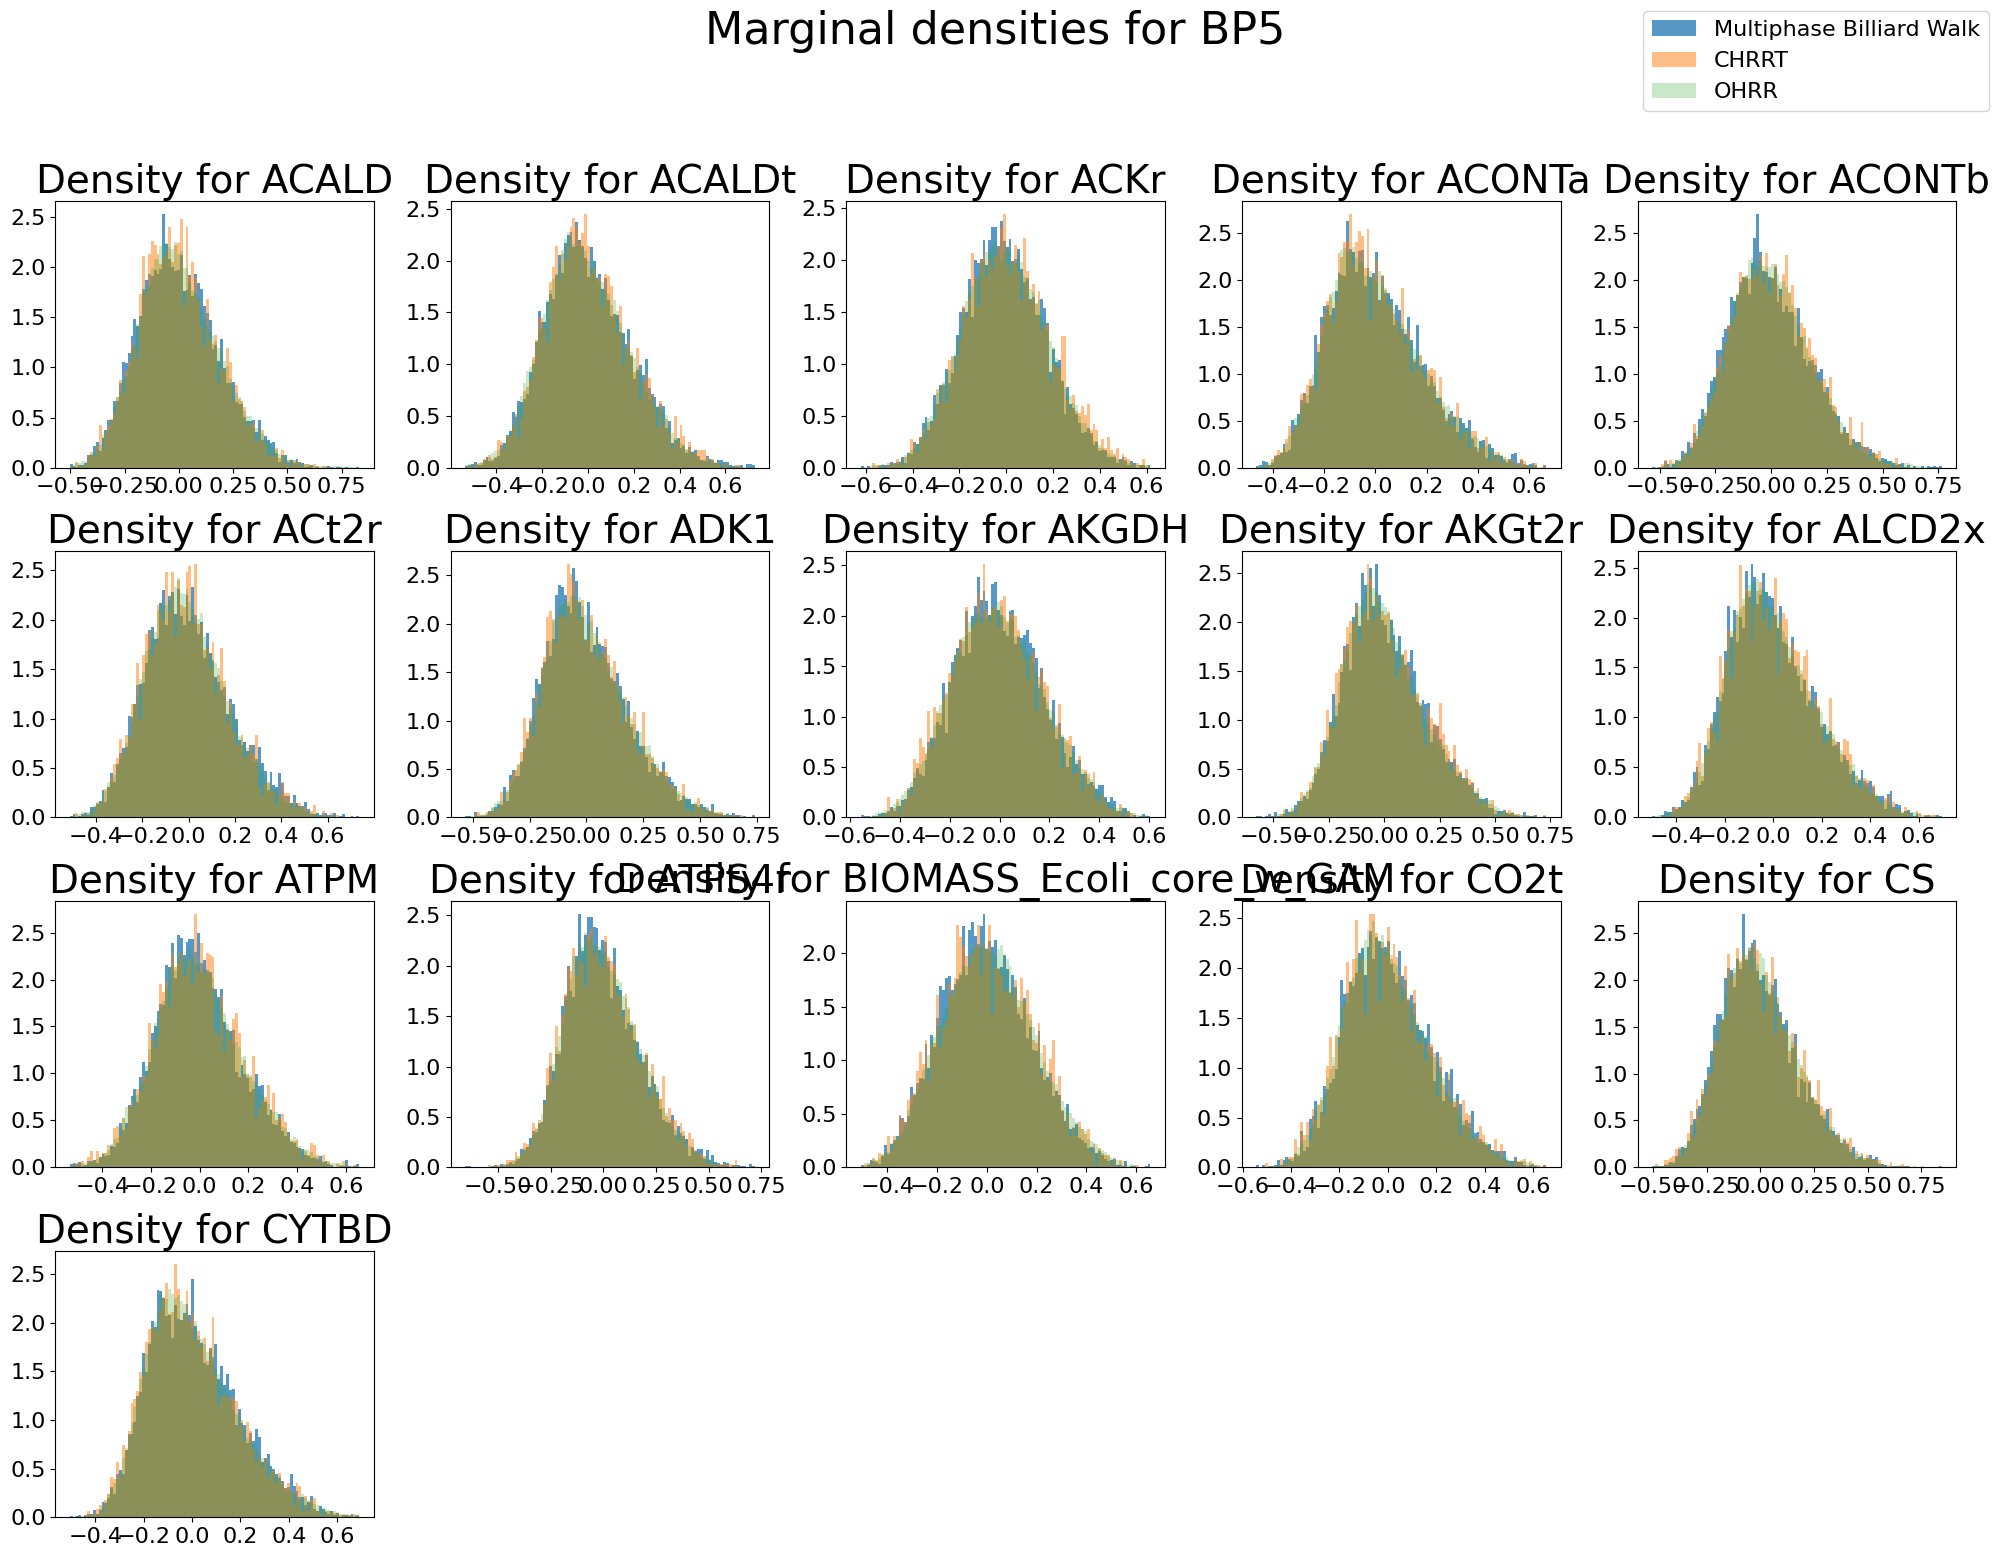

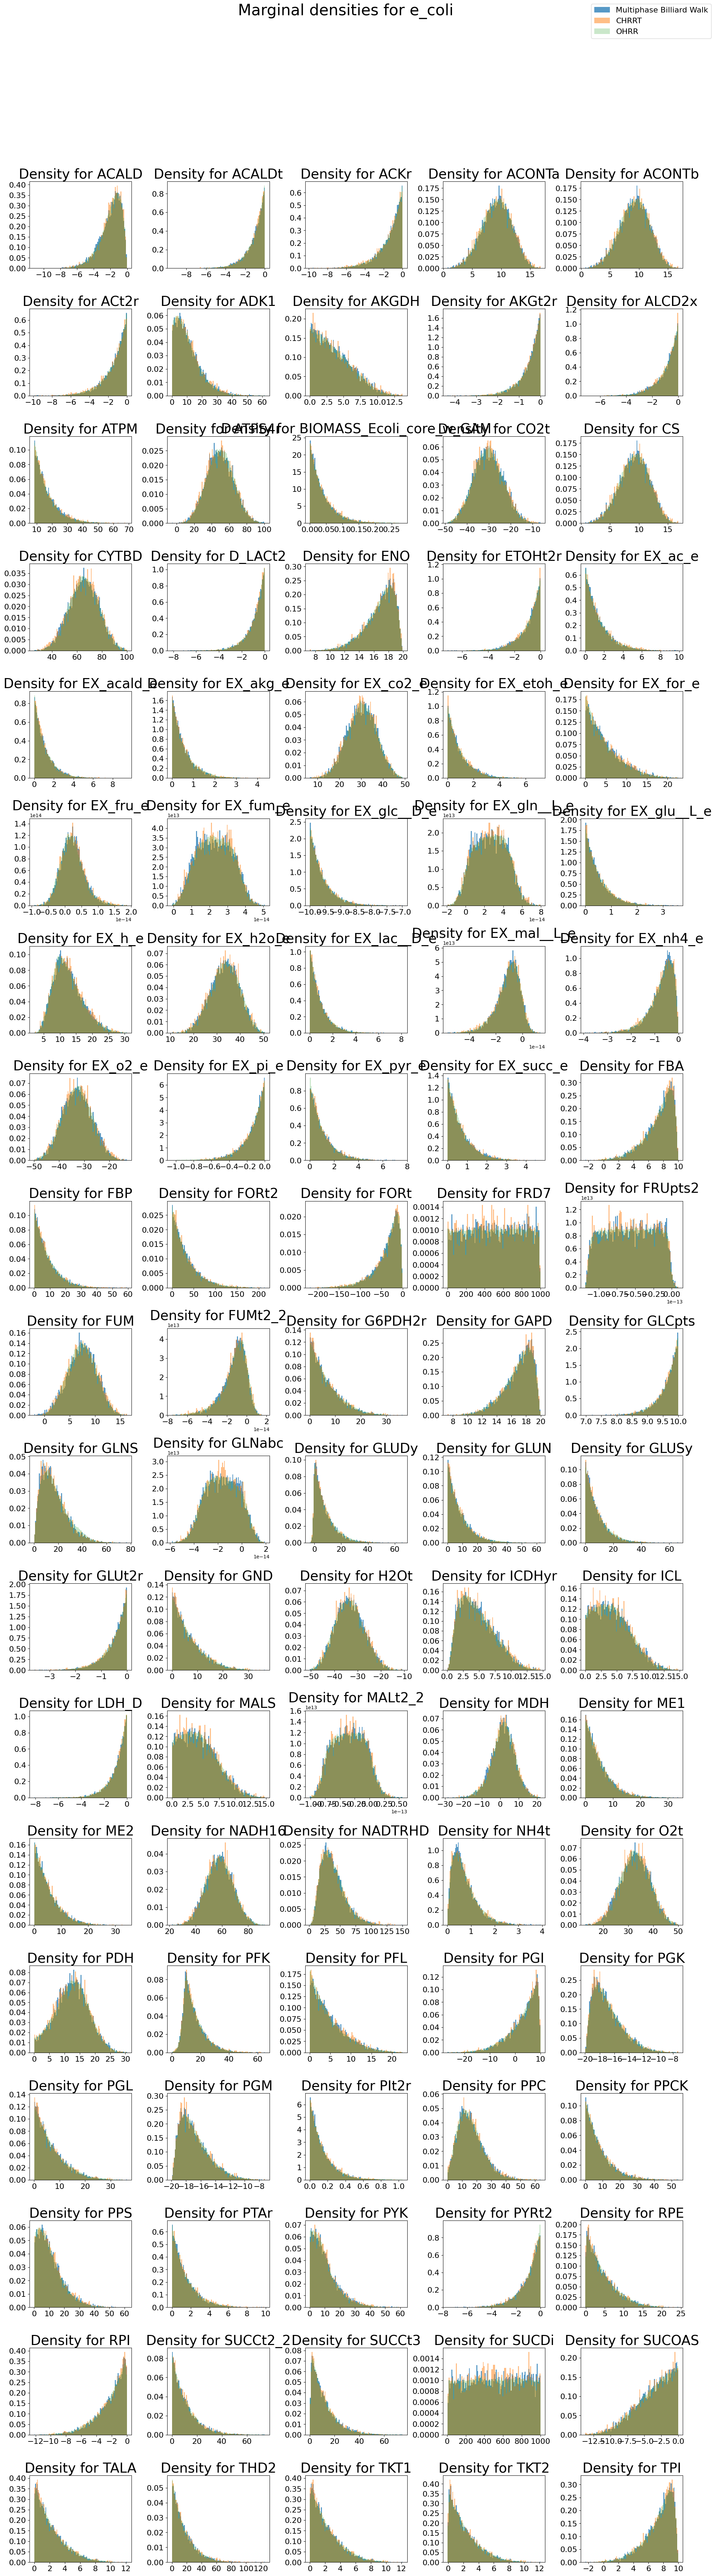

In [11]:
for problem_selection in samples.keys():
    n_dims = samples[problem_selection]["CHRRT"].shape[2]
    n_cols = 5
    n_rows = int(n_dims / n_cols) + 1
    plt.figure(figsize=(n_cols * 4, n_rows * 4))
    plt.subplot(n_rows, n_cols, 1)
    plt.suptitle(
        "Marginal densities for " + problem_selection, y=1.0, fontsize=title_fs
    )
    for dim in range(n_dims):
        plt.subplot(n_rows, n_cols, dim + 1)
        plt.title(f"Density for {parameter_names[dim]}", fontsize=title_fs - 4)
        _, bins, _ = plt.hist(
            np.concatenate(samples[problem_selection]["Billiard walk"], axis=0)[:, dim],
            bins=100,
            density=True,
            label="Multiphase Billiard Walk" if dim == 0 else None,
            alpha=0.75,
            color="C0",
        )
        _ = plt.hist(
            np.concatenate(samples[problem_selection]["CHRRT"], axis=0)[:, dim],
            bins=bins,
            alpha=0.5,
            density=True,
            label="CHRRT" if dim == 0 else None,
            color="C1",
        )
        _ = plt.hist(
            np.concatenate(samples[problem_selection]["OHRR"], axis=0)[:, dim],
            bins=bins,
            alpha=0.25,
            density=True,
            label="OHRR" if dim == 0 else None,
            color="C2",
        )
        plt.xticks(fontsize=tick_fs)
        plt.yticks(fontsize=tick_fs)

    plt.figlegend(fontsize=legend_fs)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()